# FINANCIAL ASSET PRICE PREDICTOR : UDACITY DATA SCIENTIST CAPSTONE PROJECT

# Introduction 

This project is the capstone project of Udacity Data Scientist nano-degree. For this project, I built a model to predict stock/ETF (Exchange Traded Funds)
prices. My personal professional background is in Finance and Investments. One of the reasons why I’m learning Data Science is to utility this powerful tool in the financial sector. The modern  Financial sectors consumers and generate enormous amount of date on daily basis. More than 90% of the daily trading volume of the major stock exchanges are conducted by computer program and algorithms. Machine learning and deep learning has become an essential tool for automate complicated trading decision making and trade execution process.  

In this project, I’m using LSTM model to predict stocks/ asset price a day in the future. Long short-term memory model( LSTM) is a RNN ( Recurrent Neural Network) architecture. LSTMs are extremely effective tool for sequence prediction problems. Since LTSM has feedback connection, it’s good at processing sequential of data, such as : historical financial assets prices. 



### Import all the libraries and packages 

In [81]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pandas_datareader import data as pdr 
import math 
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
%matplotlib inline
print('libraries imported')

libraries imported


## Load and Clean Dataset

### Download the Financial Data : Historical  Asset price

* In this project I used python package yfinance to download historical  stock prices
* For more information about this python package, please visit https://pypi.org/project/yfinance/

In [82]:
# First define a function to download data as dataframe 
# yfiance valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# The default interval is '1d')
# This function can take a single symbol or multiple symbol separated by space

def download_data(symbol, start_date, end_date, interval):
    '''input: symbol as string. It can be single ticker symbol or multiple symbol separated by space
       input: start_date & end_date as str, e.g:2017-01-01 
       output: return a dataframe 
       output: open, high, low , close, Adj Close
    '''
    yf.pdr_override() 
    data = pdr.get_data_yahoo(symbol, start=start_date, end=end_date, interval = interval)
    return data 

##### Download Stock Price data

* With yfinance library, you can download one or multiple stocks' price
* However, if we download multiple stocks price, the data will have multiple levels of column names, so we need to flat the column names

In [83]:
# download the data
# download multiple historical price of stocks and index
# this function can be used to download multiple or single stock/financial asset
# AAPL: ticker symbol of Apple stock,  ^VIX the ticker symbol of COBE volatility index
dataMulti = download_data("AAPL SPY QQQ ^VIX", "2000-01-01", "2022-03-30","1d")

[*********************100%***********************]  4 of 4 completed


In [84]:
# inspected the data downloaded 
dataMulti.head()

Adj Close                                      Close            \
                AAPL        QQQ        SPY       ^VIX      AAPL       QQQ   
Date                                                                        
1999-12-31  0.786033  79.050392  97.509445  24.639999  0.917969  91.37500   
2000-01-03  0.855797  81.970184  96.555130  24.209999  0.999442  94.75000   
2000-01-04  0.783644  76.346909  92.779175  27.010000  0.915179  88.25000   
2000-01-05  0.795111  74.400345  92.945190  26.410000  0.928571  86.00000   
2000-01-06  0.726304  69.290771  91.451431  25.730000  0.848214  80.09375   

                                     High           ...         Low  \
                 SPY       ^VIX      AAPL      QQQ  ...         SPY   
Date                                                ...               
1999-12-31  146.8750  24.639999  0.918527  93.1875  ...  146.250000   
2000-01-03  145.4375  24.209999  1.004464  96.1875  ...  143.875000   
2000-01-04  139.7500  27.010000  0.987723  93.5000  ...  139.640625   
2000-01-05  140.0000  26.410000  0.987165  89.6250  ...  137.250000   
2000-01-06  137.7500  25.730000  0.955357  88.0000  ...  137.750000   

                           Open                                    Volume  \
                 ^VIX      AAPL      QQQ        SPY       ^VIX       AAPL   
Date                                                                        
1999-12-31  24.450001  0.901228  92.6250  146.84375  25.030001  163811200   
2000-01-03  23.980000  0.936384  96.1875  148.25000  24.360001  535796800   
2000-01-04  24.799999  0.966518  92.0000  143.53125  24.940001  512377600   
2000-01-05  25.850000  0.926339  87.5000  139.93750  27.980000  778321600   
2000-01-06  24.700001  0.947545  86.8750  139.62500  26.680000  767972800   

                                     
                 QQQ       SPY ^VIX  
Date                                 
1999-12-31  14464400   3172700    0  
2000-01-03  36345200   8164300    0  
2000-01-04  33786600   8089800    0  
2000-01-05  42496600  12177900    0  
2000-01-06  37134800   6227200    0  

[5 rows x 24 columns]

* Open, the price at the open of a trading day 
* Close, is the price at the close of a trading day
* Adj Close: The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. Such as stock splits
* High, the highest price of a trading day
* Low, the lowest price of a trading day

In [85]:
# for multiple tickers, the column name of this dataframe has multiple levels, we need to flatten it
def rename_column(df):
    '''
    input: a dataframe with multiple levels of column name
    output: a dataframe with flated column name 
    '''
    col = list(df.columns)
    newcol = [i[0] +' '+ i[1] for i in col]
    dfCOPY = df.copy()
    dfCOPY.columns = [''] * len(dfCOPY.columns)
    dfCOPY.columns = newcol
    return dfCOPY

In [86]:
stocks = rename_column(dataMulti)
stocks.head()

,Adj Close AAPL,Adj Close QQQ,Adj Close SPY,Adj Close ^VIX,Close AAPL,Close QQQ,Close SPY,Close ^VIX,High AAPL,High QQQ,...,Low SPY,Low ^VIX,Open AAPL,Open QQQ,Open SPY,Open ^VIX,Volume AAPL,Volume QQQ,Volume SPY,Volume ^VIX
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0.786033,79.050392,97.509445,24.639999,0.917969,91.37500,146.8750,24.639999,0.918527,93.1875,...,146.250000,24.450001,0.901228,92.6250,146.84375,25.030001,163811200,14464400,3172700,0
2000-01-03,0.855797,81.970184,96.555130,24.209999,0.999442,94.75000,145.4375,24.209999,1.004464,96.1875,...,143.875000,23.980000,0.936384,96.1875,148.25000,24.360001,535796800,36345200,8164300,0
2000-01-04,0.783644,76.346909,92.779175,27.010000,0.915179,88.25000,139.7500,27.010000,0.987723,93.5000,...,139.640625,24.799999,0.966518,92.0000,143.53125,24.940001,512377600,33786600,8089800,0
2000-01-05,0.795111,74.400345,92.945190,26.410000,0.928571,86.00000,140.0000,26.410000,0.987165,89.6250,...,137.250000,25.850000,0.926339,87.5000,139.93750,27.980000,778321600,42496600,12177900,0
2000-01-06,0.726304,69.290771,91.451431,25.730000,0.848214,80.09375,137.7500,25.730000,0.955357,88.0000,...,137.750000,24.700001,0.947545,86.8750,139.62500,26.680000,767972800,37134800,6227200,0


In [87]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5597 entries, 1999-12-31 to 2022-03-29
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close AAPL  5597 non-null   float64
 1   Adj Close QQQ   5597 non-null   float64
 2   Adj Close SPY   5597 non-null   float64
 3   Adj Close ^VIX  5597 non-null   float64
 4   Close AAPL      5597 non-null   float64
 5   Close QQQ       5597 non-null   float64
 6   Close SPY       5597 non-null   float64
 7   Close ^VIX      5597 non-null   float64
 8   High AAPL       5597 non-null   float64
 9   High QQQ        5597 non-null   float64
 10  High SPY        5597 non-null   float64
 11  High ^VIX       5597 non-null   float64
 12  Low AAPL        5597 non-null   float64
 13  Low QQQ         5597 non-null   float64
 14  Low SPY         5597 non-null   float64
 15  Low ^VIX        5597 non-null   float64
 16  Open AAPL       5597 non-null   float64
 17  Open QQQ       

In [88]:
# check missing data 
stocks.isna().sum()

Adj Close AAPL    0
Adj Close QQQ     0
Adj Close SPY     0
Adj Close ^VIX    0
Close AAPL        0
Close QQQ         0
Close SPY         0
Close ^VIX        0
High AAPL         0
High QQQ          0
High SPY          0
High ^VIX         0
Low AAPL          0
Low QQQ           0
Low SPY           0
Low ^VIX          0
Open AAPL         0
Open QQQ          0
Open SPY          0
Open ^VIX         0
Volume AAPL       0
Volume QQQ        0
Volume SPY        0
Volume ^VIX       0
dtype: int64

In [89]:
# Check duplicate data
stocks.duplicated().sum()

0

### Explore Data, Data Visualization and the Simple Moving Average Strategy 

* This section is a demo about how can we utilise the data
* We will explore the data and define a simple moving average strategy. In order to keep it within the scope of this project, I won't discussing optimization of this strategy
* The book Python for Finance by Yves Hilpisch is extremely helpful
* In this section Generate Simple Moving Averages using Adjusted close price

There are two types of basic and simple trade strategies: trend following and mean reversion. A trend following strategy is to identify the stocks that are in up or down trend, we would like to long(buy) when the stock price is trending up, and short short selling) when the stock price is trending down.  A mean reversion trading strategy based on the assumption that a financial asset’s price will eventually reverse to the long-term mean.  So, we will sell an overbought asset and buy an overbought asset and expecting the price will reverse to the mean. The deviation from the long-term mean is measured by standard deviation. 

 Funds and trading house seldom use strategies that is so simple, however this project is not about how to earn money on the financial market. To keep it relevant and more understandable, in the Data Exploration section, I will demonstrate how to build a Simple Moving Average strategy which is a basic trend following strategy. If you are interested in more advanced topics, Udacity’s. AI For Trading nanodegree might be a good place to start

In [90]:
# We have downloaded multiple columns, but here we only need Adjusted close price
# Change the variable symbol if you need to run it with other stock data
# Define a function to cleanup data 
def cleanData(symbol, df):
    '''
       input: 
             df: a dataframe that contains stock data
             symbol: symbol of a stock that you're intereted in 
       output: cleaned dataframe with one column: price
    '''
    symbol = symbol
    close = stocks.loc[:, stocks.columns.str.startswith('Adj Close')]
    strSymbol = 'Adj Close '+ symbol
    stock = pd.DataFrame(close[strSymbol])
    stock.rename(columns={strSymbol: 'price'}, inplace=True)
    return stock 

In [91]:
# Clean the data and get a dataframe with the index of date and a col of price
symbol = 'QQQ'
stock = cleanData( symbol,stocks)
stock.head()

,price
Date,
1999-12-31,79.050392
2000-01-03,81.970184
2000-01-04,76.346909
2000-01-05,74.400345
2000-01-06,69.290771


#### Investigate the relationship between a financial asset and Volatility Index (VIX)

In [92]:
LogReturns = stocks[["Adj Close ^VIX", "Adj Close QQQ"]]
LogReturns = np.log(LogReturns/LogReturns.shift(1))
LogReturns.dropna(inplace = True)
LogReturns.head()

,Adj Close ^VIX,Adj Close QQQ
Date,,
2000-01-03,-0.017605,0.036270
2000-01-04,0.109441,-0.071068
2000-01-05,-0.022464,-0.025827
2000-01-06,-0.026085,-0.071149
2000-01-07,-0.169424,0.116612


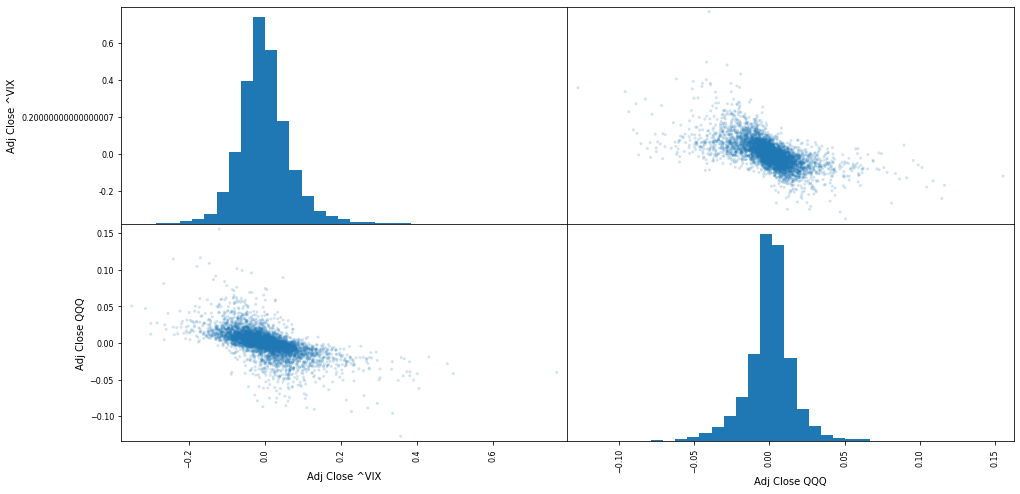

In [93]:
pd.plotting.scatter_matrix(LogReturns, 
                           alpha =0.2,
                           diagonal = 'hist', 
                           hist_kwds ={'bins': 35}, 
                           figsize =(16,8));


##### Let's plot and identify the Ordinary least squares (OLS) regression 

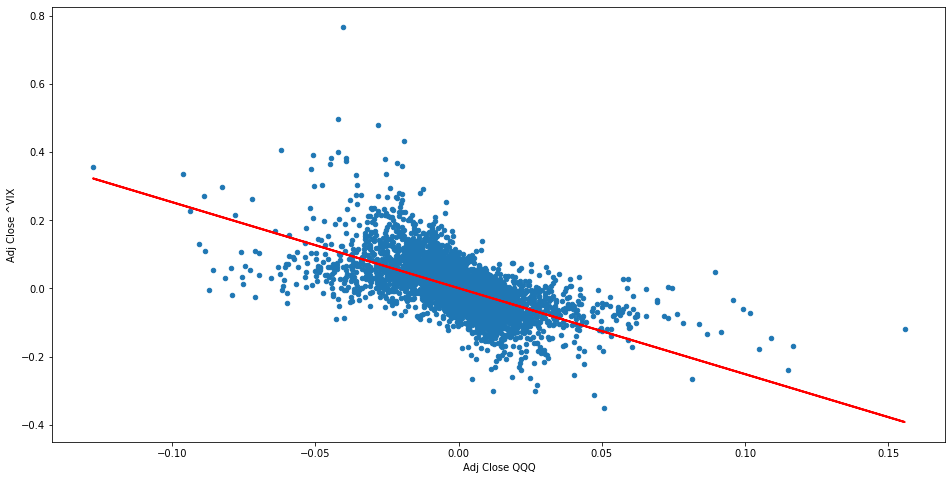

In [94]:
reg = np.polyfit(LogReturns['Adj Close QQQ'],LogReturns['Adj Close ^VIX'], deg =1)
ax = LogReturns.plot(kind = 'scatter', x = 'Adj Close QQQ', y = 'Adj Close ^VIX', figsize =(16,8))
ax.plot(LogReturns['Adj Close QQQ'], np.polyval(reg, LogReturns['Adj Close QQQ']),'r', lw=2);


* As we can see from the plot above, the return of ETF QQQ has a strong negative correlation with Volatility index
* The higher the volatility the lower the return 

### Use the prices of Exchange Traded Funds (ETF) to build a strategy 

* Ticker Symbol QQQ
* Name: Invesco QQQ ETF

* "The Invesco QQQ ETF (NASDAQ: QQQ) is an index fund that mirrors the Nasdaq-100 index, which consists of the 100 largest U.S. and international nonfinancial companies listed on the Nasdaq Stock Market based on market cap." For more information, see Invesco's home page https://www.invesco.com/qqq-etf/en/home.html

* In this project, I used Invesco QQQ index ETF (Exchange traded fund) to build a strategy (included in Data exploration section) and build LTSM model. "The Invesco QQQ ETF (NASDAQ: QQQ) is an index fund that mirrors the Nasdaq-100 index, which consists of the 100 largest U.S. and international nonfinancial companies listed on the Nasdaq Stock Market based on market cap."
For more information, see Invesco’s home page: https://www.invesco.com/qqq-etf/en/home.html

* In general, invest in index tracking Exchange Traded Funds (ETF) is a great choice for individual investors. Since it tracks a group of companies(constitutions of an index) It's an easy way to have a diversifed invest portifolio while not spending too much energy on acquiring the sector sepcific knowledge 


##### Simple Moving Average (SMA)  Formula 

SMA is a rather simple concept, it's just a rolling average 
SMA = ( Sum ( Price, n ) ) / n    
Where: n = Time Period

Don’t underestimate the power of simplicity. A profitable trading strategy doesn’t need to be overly complicated. The key is that the execution needs to be consistence.


In [95]:
# Define a funtion to generate Simple Moving average
# remember, SMA is just a rolling mean 
def SMA_Position(stock, smafast, smaslow):
    '''
       input: stock, a dataframe that contains stock data 
       smafast: an int number, fast moving average
       smaslow: an int number, slow moving average
       output: return the dataframe stock with an extra column,position 
    '''
    SmaFast = smafast
    SmaSlow = smaslow
    stock['SmaFast'] = stock['price'].rolling(SmaFast).mean()
    stock['SmaSlow'] = stock['price'].rolling(SmaSlow).mean()
    stock.dropna(inplace =True)
    # Long Position: Long a stock when the fast SMA is above slow SMA
    # Short Position: Short a stock when the slow SMA is above the fast SMA
    stock['Position'] = np.where(stock['SmaFast']> stock['SmaSlow'],1 ,-1)
    return stock

In [96]:
# Each year, there are around 254 trading days, so we use period n = 254 as slow moving average 
# Each month, on average there are 21 trading days, so we use period n = 42 as fast moving average
# Fast moving average with period n = 42
# Slowe moving average with period =  254
stock = SMA_Position(stock = stock, smafast=42,smaslow = 254)

In [97]:
stock.head()

,price,SmaFast,SmaSlow,Position
Date,,,,
2001-01-02,46.229889,59.311609,77.627303,-1
2001-01-03,54.015976,58.929257,77.528742,-1
2001-01-04,53.042713,58.503134,77.414854,-1
2001-01-05,48.987434,57.958572,77.307140,-1
2001-01-08,49.528149,57.439757,77.209218,-1


In [98]:
# caculate the log returns of 'buy and hold' and SMA strategy
stock['Return'] = np.log(stock['price']/stock['price'].shift(1))
stock['Strategy'] = stock['Position'].shift(1)*stock['Return']
stock.dropna(inplace =True)
stock.round(4).head()

,price,SmaFast,SmaSlow,Position,Return,Strategy
Date,,,,,,
2001-01-03,54.0160,58.9293,77.5287,-1,0.1557,-0.1557
2001-01-04,53.0427,58.5031,77.4149,-1,-0.0182,0.0182
2001-01-05,48.9874,57.9586,77.3071,-1,-0.0795,0.0795
2001-01-08,49.5281,57.4398,77.2092,-1,0.0110,-0.0110
2001-01-09,49.5281,56.9274,77.1314,-1,0.0000,-0.0000


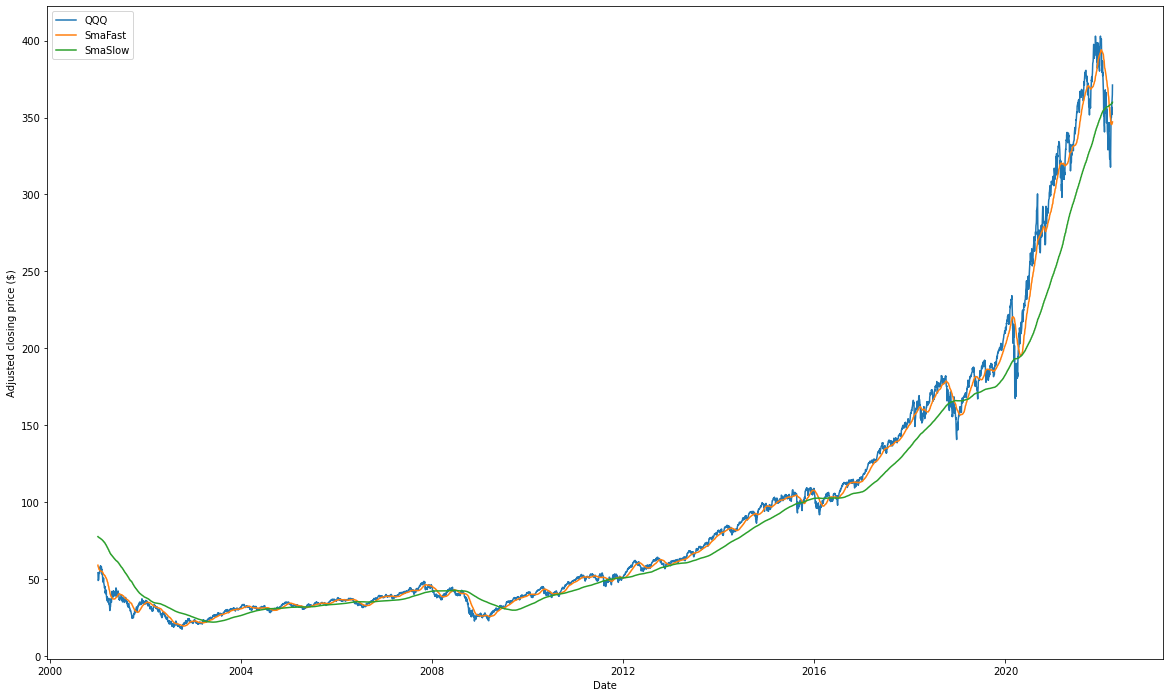

In [99]:
# Plot out the strategy
# We long/buy apple stock or derivatives if Fast Simple Moving Average is above Slow moving average 

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(stock.index, stock['price'], label= symbol)
ax.plot(stock.index, stock['SmaFast'], label='SmaFast')
ax.plot(stock.index, stock['SmaSlow'], label='SmaSlow')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()


In [100]:
np.exp(stock[['Return','Strategy']].sum())

Return      8.029221
Strategy    9.857585
dtype: float64

In [103]:
# caculate the annualized volatility
stock[['Return','Strategy']].std()*254**0.5

Return      0.251734
Strategy    0.251718
dtype: float64

   * As we can see from above, SMA strategy generate higher return than benchmark ("Buy and hold") 
   * The annualized volatility, is almost the same. SMA's volatility is slightly lower

#### Plot the Position( Long or Short) and Return of the strategy

* Blue Line: the cumulative return of the defined time period ( A simple buy and hold strategy)
* Orange Line: Simple Moving Average(SMA)strategy's return
* As you can see below, Given almost the same annulized volatilities, SMA strategy outperformed the "buy and hold" benchmark. 

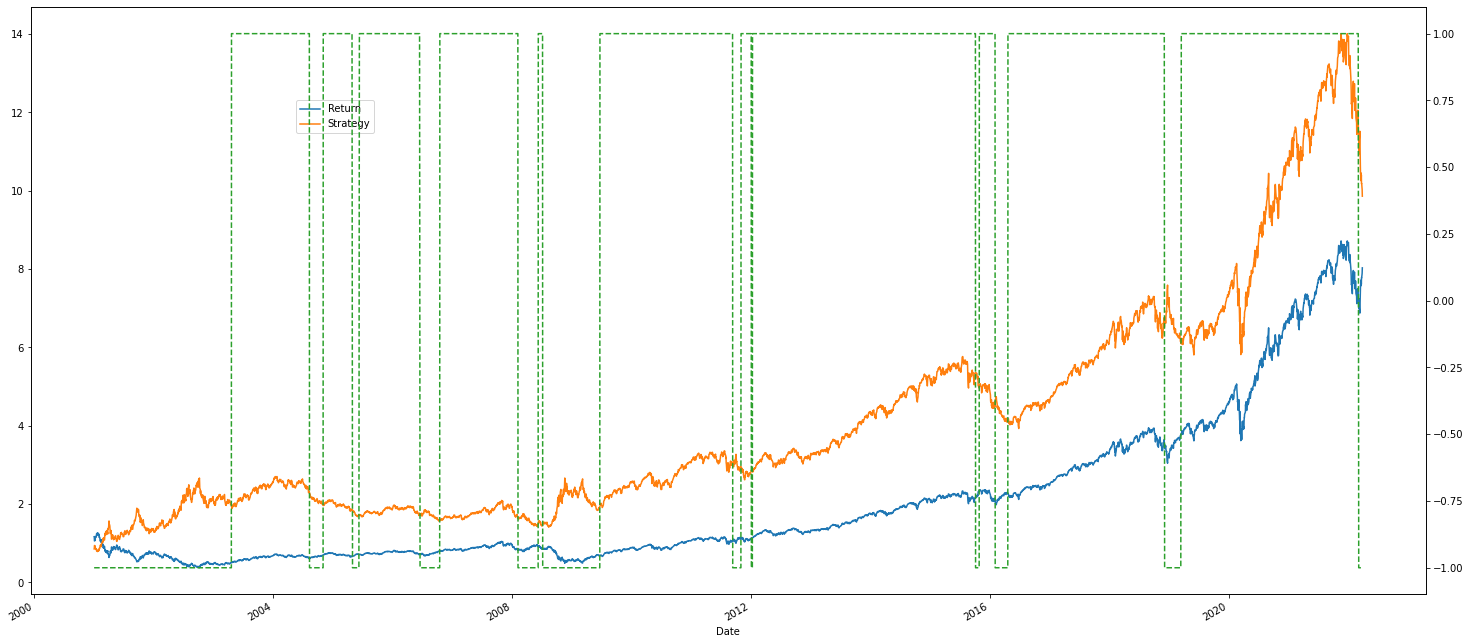

In [102]:
ax = stock[['Return', 'Strategy']].cumsum().apply(np.exp).plot(figsize =(25,12))
stock['Position'].plot(ax = ax, secondary_y ='Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85))


In [138]:
stock.head()

,price,SmaFast,SmaSlow,Position,Return,Strategy
Date,,,,,,
2014-12-29,80.019997,78.771666,76.630599,1,-0.009453,-0.009453
2014-12-30,79.220001,78.895833,76.695999,1,-0.010048,-0.010048
2014-12-31,78.019997,78.911666,76.717399,1,-0.015264,-0.015264
2015-01-02,78.449997,79.033332,76.712599,1,0.005496,0.005496
2015-01-05,77.190002,79.241666,76.688999,1,-0.016191,-0.016191


## Use recurrent neural network model: LSTM to predict financial asset price

An extremly nice blog posts about LSTM, Long and Short term memory model
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/

* Long short-term memory model( LSTM) is a RNN ( Recurrent Neural Network) architecture. LSTMs are extremely effective tool for sequence prediction problems. Since LTSM has feedback connection, it’s good at processing sequential of  historical data, such as : historical financial asset prices. 
* RNNs are analogous to the learning process of humans, just like us, it remembers some useful information from the past (feedback connection) and forget some none important information


In [105]:
# First make a copy of cleaned dataframe 
data = stock

In [106]:
# only keep Adj Close(price) as a dataframe
PRICE = data.filter(['price'])
# convert the dataframe to a numpy array 
dataset = PRICE.values 
# Here we use 80% of the data as training data
train_data_len = math.ceil(len(dataset)* .8)
train_data_len

4275

#### Normalizing the Data and split data into training & testing sets


In [107]:
# Normalize and scale the data and transform it into a 0 to 1 range 
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.09507013],
       [0.09254629],
       [0.08203024],
       ...,
       [0.88685504],
       [0.9012731 ],
       [0.91755824]])

In [108]:
# Create the training data set
# row: 0 to the lenght of training data, and get all the columns 
train_data = scaled_data[0: train_data_len, :]

In [109]:
# define x_train, y_train 
x_train =[]
y_train =[]
for i in range (50, len(train_data)):
    x_train.append(train_data[i-50:i,0])
    y_train.append(train_data[i,0])
    if i <= 51:
        print(x_train)
        print(y_train)
        #print()

[array([0.09507013, 0.09254629, 0.08203024, 0.08343241, 0.08343241,
       0.09002245, 0.09394838, 0.09573612, 0.09405352, 0.09829499,
       0.10432416, 0.10376336, 0.1039035 , 0.10702322, 0.10558604,
       0.09969716, 0.10204568, 0.10530571, 0.10474485, 0.09924846,
       0.10115533, 0.09307908, 0.09296691, 0.09319124, 0.09094785,
       0.08688724, 0.08152551, 0.08305102, 0.0789456 , 0.0838811 ,
       0.0860123 , 0.07867637, 0.07387551, 0.07053279, 0.06941109,
       0.06981495, 0.07199102, 0.06492425, 0.061447  , 0.06447556,
       0.05976445, 0.06167138, 0.06582167, 0.06586651, 0.06380258,
       0.05617503, 0.04989344, 0.05471677, 0.05314637, 0.04955692])]
[0.04742573601554501]
[array([0.09507013, 0.09254629, 0.08203024, 0.08343241, 0.08343241,
       0.09002245, 0.09394838, 0.09573612, 0.09405352, 0.09829499,
       0.10432416, 0.10376336, 0.1039035 , 0.10702322, 0.10558604,
       0.09969716, 0.10204568, 0.10530571, 0.10474485, 0.09924846,
       0.10115533, 0.09307908, 0.092

In [110]:
# convert the x_train , y_train to numpy arrays
# LSTM model is expecting 3 dimensional data, but we only have 2 dimensional --> reshape the data
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(4225, 50, 1)

#### Build And Compile the Model 

* That return sequences return the hidden state output for each input time step.
* The model has 100 neurons 
* Dropout, 20% of 100 neurons will be ignored randomly during each iteration.

In [122]:
model = Sequential()
# 1st lstm layer
model.add(LSTM(units=100,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
# 2st lstm layer
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
# 3st lstm layer
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
# 3st lstm layer 
model.add(LSTM(units=100,return_sequences= False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')

#### Train the model 

"On sequence prediction problems, it may be desirable to use a large batch size when training the network and a batch size of 1 when making predictions in order to predict the next step in the sequence."

There is an intereting reading about batch_size on machinelearningmastery.com:
https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/


In [123]:
## train the model
model.fit(x_train,y_train, batch_size =32, epochs =10)

Epoch 1/10
133/133 [==============================] - 16s 79ms/step - loss: 6.3847e-04
Epoch 2/10
133/133 [==============================] - 10s 76ms/step - loss: 1.3644e-04
Epoch 3/10
133/133 [==============================] - 11s 84ms/step - loss: 1.4829e-04
Epoch 4/10
133/133 [==============================] - 11s 83ms/step - loss: 1.1161e-04
Epoch 5/10
133/133 [==============================] - 11s 82ms/step - loss: 1.1466e-04
Epoch 6/10
133/133 [==============================] - 10s 77ms/step - loss: 1.7838e-04
Epoch 7/10
133/133 [==============================] - 11s 79ms/step - loss: 1.0303e-04
Epoch 8/10
133/133 [==============================] - 11s 79ms/step - loss: 8.5522e-05
Epoch 9/10
133/133 [==============================] - 11s 81ms/step - loss: 9.2272e-05
Epoch 10/10
133/133 [==============================] - 11s 80ms/step - loss: 7.7382e-05


In [124]:
# create test data set
test_data = scaled_data[train_data_len -50:, :]
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(50, len(test_data)):
    x_test.append(test_data[i-50:i,0])

x_test = np.array(x_test)

In [125]:
# reshape the data, becasue the lstm model is expecting a 3 dimensional dataset 
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [126]:
# Use the model to predict the value 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions 

array([[145.99335],
       [146.11646],
       [146.23177],
       ...,
       [312.3286 ],
       [313.91412],
       [315.7551 ]], dtype=float32)

##  Evaluate The Model

* To evaluate the model, we us RSME, Root Mean Square Error which is the standard deviation of the residuals (prediction errors). Different parameters will be used to modify the model and caculate the RSME 

* We will also use this model to predict the stock prices in the same sector or other assets class 


In [127]:
# Get the mean squared error (RMSE), the lower the value of RMSE, the better the model fits
rsme = np.sqrt(np.mean(predictions - y_test)**2)
print( "The Root Mean Square Error is :" + str(rsme.round(4)))

The Root Mean Square Error is :16.0173


The RMSE is rather small, the model's reasult seems to be rather reasonable

In [128]:
# create a validation dataset
train = data.iloc[: train_data_len]
finalDF = data.iloc[ train_data_len:]
finalDF['Predictions'] = predictions

/var/folders/k3/1lf551f54pvcy1bpp1lld73r0000gp/T/ipykernel_4764/3730383151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['Predictions'] = predictions


In [129]:
finalDF.head(10)

,price,SmaFast,SmaSlow,Position,Return,Strategy,Predictions
Date,,,,,,,
2018-01-02,154.061447,150.527996,135.628137,1,0.017375,0.017375,145.993347
2018-01-03,155.558411,150.718875,135.786580,1,0.009670,0.009670,146.116455
2018-01-04,155.830627,150.922934,135.950759,1,0.001748,0.001748,146.231766
2018-01-05,157.395645,151.130535,136.117079,1,0.009993,0.009993,146.368240
2018-01-08,158.008041,151.340707,136.283346,1,0.003883,0.003883,146.554779
2018-01-09,158.017761,151.549031,136.447072,1,0.000062,0.000062,146.811340
2018-01-10,157.648346,151.734241,136.605323,1,-0.002341,-0.002341,147.142212
2018-01-11,158.727371,151.963848,136.766306,1,0.006821,0.006821,147.535034
2018-01-12,159.893814,152.221460,136.930857,1,0.007322,0.007322,147.976654


### Visualize the Model's Prediction 

Now we are going to visualize the LTSM model's prediction and compare the actual prices and predicited prices

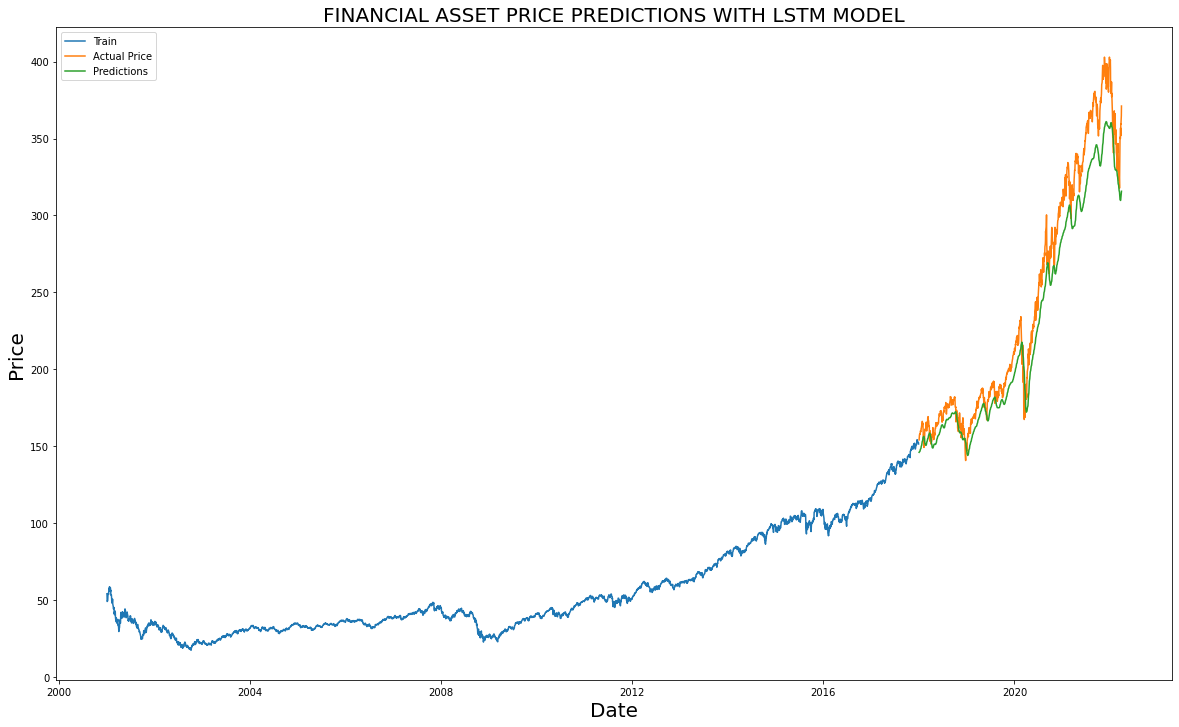

In [130]:
# plot out the actual price and the 
plt.figure(figsize =(20,12))
plt.title('FINANCIAL ASSET PRICE PREDICTIONS WITH LSTM MODEL',fontsize = 20)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Price', fontsize =20)
plt.plot(train['price'])
plt.plot(finalDF[['price', 'Predictions']])
plt.legend(['Train','Actual Price','Predictions'], loc ='upper left')
plt.show()

The plot above showed us that:

* The blue line: training data
* The orange line is the actual price 
* The green line is the predciton that LSTM model made 

We can see that the predicted price follows the trend of actual price pretty well

In [131]:
# show the actual and predicted price
finalDF.tail(20)


,price,SmaFast,SmaSlow,Position,Return,Strategy,Predictions
Date,,,,,,,
2022-03-02,346.791260,360.802035,357.675793,1,0.016640,0.016640,322.395844
2022-03-03,341.837402,359.480098,357.775617,1,-0.014388,-0.014388,321.383942
2022-03-04,336.883514,357.949134,357.892096,1,-0.014598,-0.014598,320.540558
2022-03-07,324.458862,356.246239,357.979460,-1,-0.037578,-0.037578,319.822906
2022-03-08,322.950745,354.797078,358.042964,-1,-0.004659,0.004659,319.102722
2022-03-09,334.576355,353.631139,358.186441,-1,0.035365,-0.035365,318.261658
2022-03-10,330.860962,352.475663,358.268995,-1,-0.011167,0.011167,317.307678
2022-03-11,323.999420,351.150872,358.328019,-1,-0.020957,0.020957,316.273621
2022-03-14,317.777161,349.542148,358.334526,-1,-0.019391,0.019391,315.160217


#### Save the Model

In [132]:
# Pretty decent result, now lets save the model 
model.save('model.h5')

### Predict prices of other stocks and financial asset and evaluate the robustness of the LSTM

The model is trained with Google's stock price. To see how this model perform, now we're going to use this model to predict different asset class: such as stock index and digital currency. 

 Predict Google stock price

In [133]:
# Define a function that download data and predict price of the desired financial asset
def predict_price(symbol,startdate,enddate,interval):
    '''
    input: symbol of the stock/financial instrument as a string
    input: startdate & enddate & interval as string
    output: predicted price for the next dag
    '''
    DFPred = download_data(symbol, startdate, enddate,interval)
    DFPred = DFPred.filter(['Adj Close'])
    # Get the last 50 day Adj Close price and convert the df into an array
    last_50_days = DFPred[-50:].values
    # Transform the data into value between 0 and 1
    last_50_days_scaled = scaler.transform(last_50_days)
    # Creat an empty list and append the last 50 days and convert it into numply array 
    X_test =[]
    X_test.append(last_50_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    # Get the predicted scaled price and undo the scaling
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    str_pred = str(pred_price[0][0])
    print( "The predicted price is " + str_pred)

In [149]:
#model = keras.models.load_model('model.h5')

##### Use the model to predict price of 1 day in the future and compare with the actual result

In [154]:
symbol = "QQQ"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"

predict_price(symbol, startdate, enddate, interval)
# Take a look of the actual price of Nov 2021
QQQ_price = download_data("QQQ", "2021-12-02", "2021-12-02","1d")
QQQ_price

[*********************100%***********************]  1 of 1 completed
The predicted price is 360.69687
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,398.279999,400.480011,386.640015,387.119995,386.148804,77766500


In [136]:
# Run the model in the future by load the model 
#model = keras.models.load_model('model.h5')

##### Let's use the model to predict the price of other stock and financial asset


In [156]:
symbol = "FB"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-12-02", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 314.53964
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,330.290009,330.5,310.290009,310.600006,310.600006,30329600


##### Evaluate the model and use the model to predict the price of Amsterdam AEX index

In [160]:
symbol = "^AEX"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-12-01", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 587.0219
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,783.840027,792.159973,783.840027,790.700012,790.700012,90800


##### Use the Model to predict the price of Microsoft stock

In [161]:
symbol = "MSFT"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-12-02", "2021-12-02","1d")
new


[*********************100%***********************]  1 of 1 completed
The predicted price is 312.5284
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,335.130005,339.279999,329.390015,330.079987,329.398895,33337600



##### Use the Model to predict the price of  Shell plc

In [164]:
symbol = "SHEL"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-12-02", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 42.934303
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,43.02,43.115002,41.560001,41.59,41.59,6006255


##### Use the Model to predict the price of HERMES

In [168]:
symbol = "RMS.PA"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-11-30", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 687.1214
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-30,1623.5,1676.5,1614.5,1653.0,1642.203613,206735
2021-12-01,1666.0,1678.0,1618.0,1668.5,1657.602539,70320


##### Use the Model to predict the price of bitcoin

In [162]:
symbol = "BTC-USD"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
# The actual price
new = download_data(symbol, "2021-12-02", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 542.3786
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,56907.964844,59041.683594,56553.082031,57229.828125,57229.828125,36858195307


Took a look of this result, the model's prediction of Bitcoin price is not even close to the actual price at all. It might have something to do with the fact that we have trained this model with a tech stock data. Difference financial assets have different price movement patterns, they trend in different way. Obviously, Bitcoine is a totally different culture than equity(stocks)

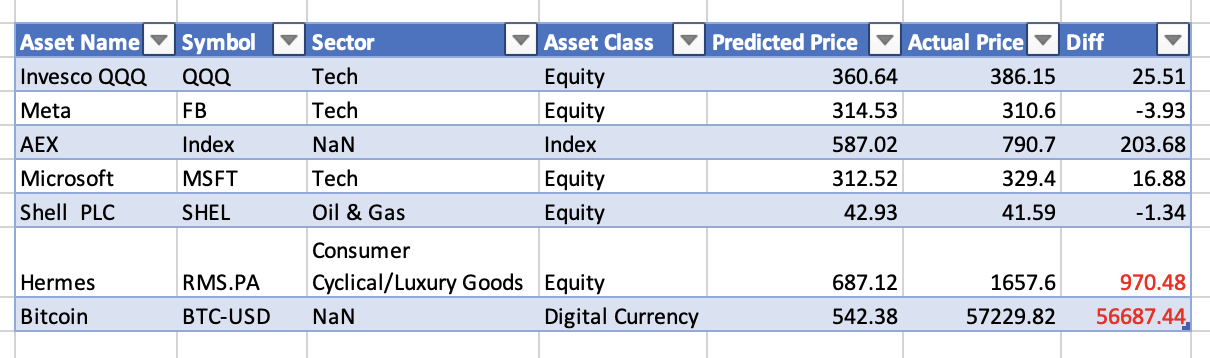

In [171]:
from IPython import display
display.Image("./result.png")


Took a look of this result, the model's prediction of Bitcoin price is not even close to the actual price at all. The same result showed up at prediction of  Hermes & AEX price. (Note: EX is a miner European Index(Amsterdam Exchange), which contains a basket of stocks across different sectors.)

It might have something to do with the fact that we have trained this model with an index Fund that tracks Tech companies. Difference financial instruments across sectors and asset’s class have different fundamentals and price movement patterns, they  behave in different way. Obviously, Bitcoin is a totally different creature than equity(stocks).

##### Train the model after adding 50 more neurons

In [169]:
model = Sequential()
# 1st lstm layer
model.add(LSTM(units=150,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
# 2st lstm layer
model.add(LSTM(units=150,return_sequences=True))
model.add(Dropout(0.2))
# 3st lstm layer
model.add(LSTM(units=150,return_sequences=True))
model.add(Dropout(0.2))
# 3st lstm layer 
model.add(LSTM(units=150,return_sequences= False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train, batch_size =32, epochs =20)
# Get the mean squared error (RMSE), the lower the value of RMSE, the better the model fits
rsme = np.sqrt(np.mean(predictions - y_test)**2)
print( "The Root Mean Square Error is :" + str(rsme.round(6)))

Epoch 1/20
133/133 [==============================] - 24s 134ms/step - loss: 5.3773e-04
Epoch 2/20
133/133 [==============================] - 17s 129ms/step - loss: 1.0132e-04
Epoch 3/20
133/133 [==============================] - 17s 125ms/step - loss: 1.0630e-04
Epoch 4/20
133/133 [==============================] - 18s 132ms/step - loss: 9.9304e-05
Epoch 5/20
133/133 [==============================] - 18s 135ms/step - loss: 8.9333e-05
Epoch 6/20
133/133 [==============================] - 17s 131ms/step - loss: 9.7710e-05
Epoch 7/20
133/133 [==============================] - 14s 108ms/step - loss: 1.2177e-04
Epoch 8/20
133/133 [==============================] - 16s 119ms/step - loss: 8.3690e-05
Epoch 9/20
133/133 [==============================] - 16s 117ms/step - loss: 8.1644e-05
Epoch 10/20
133/133 [==============================] - 18s 133ms/step - loss: 8.7655e-05
Epoch 11/20
133/133 [==============================] - 14s 109ms/step - loss: 9.1406e-05
Epoch 12/20
133/133 [=========

In [147]:
model.save('model_updated.h5')

In [148]:
symbol = "FB"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-11-30", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 641.8372
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-29,3547.639893,3596.000000,3531.500000,3561.570068,3561.570068,3265600
2021-11-30,3563.500000,3585.770020,3492.010010,3507.070068,3507.070068,4001100
2021-12-01,3545.000000,3559.879883,3441.600098,3443.719971,3443.719971,3745800


### Conclusion And Possible Improvements

The model does reasonably well when predicting the financial instruments in the same asset class and sector, that is : tech stock (equity).  

The model does not perform well when predicting the price of Bitcoin which is a in totally different asset class. In financial sector, there are many assets classes, such as Fixed Income( Bonds), Equity(stocks), Currency(Forex), Digital Assets.  Different asset classed exhibit different price movements patterns, due to the fact that prices of those assets are determined on different factors. If you are trading or invest in one particular financial instrument , it’s better to train the model consistently with the same asset class and re-train the model if you wish to predict the price of another instrument from different sector or assets class. 

To summaries, the LTSM  along is just too simply to forecast stock price, and trader&investor should definitely not trade according to the predictions. Financial market is an extremely complicated system, forecasting price movements is as difficult as forecasting weather. There are many factors can introduce dramatic changes of stock price. Use one model to predict and generate single for trading or investment decision is rather dangerous. Sometimes, It’s better to combine the results of different models. For example, utilize NLP sentiment analysis to evaluate the market sentiment, if the market sentiment is bearish and LTSM prediction also shows price drop, then we short-selling the stock; if the market sentiment is bullish and LTSM prediction also shows price increase, then we long the stock. 



### References:

* Python for finance by Yves Hilpisch https://www.oreilly.com/library/view/python-for-finance/9781492024323/

* Time Series - LSTM Model https://www.tutorialspoint.com/time_series/time_series_lstm_model.htm

* Short-term stock market price trend prediction using a comprehensive deep learning system by Jingyi Shen & M. Omair Shafiq ttps://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00333-6

* P516, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow by Aurelien Geron 

